## 2022년 01월 28일 스터디
**Dacon 대회 - 농업 환경 변화에 따른 작물 병해 진단 AI 경진대회 - [Baseline]_ResNet50 + LSTM**

대회 목표: "작물 환경 데이터"와 "작물 병해 이미지"를 이용해 "작물의 종류", "병해의 종류", "병해의 진행 정도"를 진단하는 AI 모델 개발

2022/01/28 목주영

- 커널 링크 : https://dacon.io/competitions/official/235870/codeshare/4146?page=1&dtype=recent
    - https://dacon.io/competitions/official/235870/data 링크로 들어가 데이터 다운받기
- 학습 방법 : 전체적으로 훑어보기 + 3번 필사해보기 + 공부한 내용 정리하여 개인 보관하기
- 스터디 방법 : 코드 리뷰 + 보완 설명
- 리뷰 사항 : 코드 전반적인 발표 준비 + 인사이트와 아쉬운 사항 제기 및 보완
- 역할 분담 : 1-7(#visualize bbox)+object detection : 영준 / 8-15(데이터셋 구성)+torch 주요 활용법 : 하람 /16-22+ResNet 모델 설명 : 주영 /22-28 + LSTM 모델 : 영훈 / 주요 흐름 정리 : 진열
- <span style="color:green"><b>16-22+ResNet 모델 설명 : 주영</b></span>

**머신러닝 스터디**
- 목표 : 머신러닝 관련 실습을 통해, 국내 공모전 참여 및 수상
- 스터디 방법 : 캐글, 데이콘 튜토리얼 코드 리뷰 ~ 공모전 참여
- 소요 시간 : 1시간 30분~2시간(줌 온라인)

<span style="color:blue">**인사이트, 아쉬운 사항 제기 및 보완**</span>

<ol>
    <li>설명이 너무 잘 안되어있어서 아쉽다.</li>
    <li><span style="color:red">몰랐던, 추가 설명 필요한 클래스/메서드에 대한 설명 쓰기</span></li>
    <li>오타(?) 정정</li>
    <li>movie dataset은 사용하는 데이터가 거의 모두 문자열이다. 문자를 숫자로 바꾸는 방법들을 알게되었다. (BOW 방법론: TF-IDF, CountVectorizer)</li>
    <li>다른 모델들로도 학습해보기</li>
    <li>K폴드 교차검증기법(K-fold Cross Validation) 사용하기</li>
    <li>성능 측정 지표 사용하기 -> RMSE (Root Mean Square Error, l2 norm), MAE (Mean Absolute Error, l1 norm), MSE, cost function</li>
    <li>모델을 적절하게 선택했는지 확인하는 방법들 -> Grid Search, Randomized Search, Ensemble Method 추후 사용할 예정</li>
</ol>

# Data Description

1. train : 학습용 데이터셋

	├ 10001 : 데이터 고유 아이디

	│	├ 10001.jpg : 이미지 파일

	│	├ 10001.csv : 환경 데이터

	│		└ 촬영 전 48 시간의 "측정 시각", "내부 온도", "내부 습도", "내부 이슬점", "내부 CO2", "외부 풍속", "외부 누적일사" 등의 환경 정보

	│	└ 10001.json :

	│		├ description 

	│		│	├ image : 이미지 파일 이름

	│		│	├ date : 촬영 날짜

	│		│	├ time : 촬영 시간

	│		│	├ region : 촬영 지역

	│		│	├ height : 이미지 높이

	│		│	├ width : 이미지 너비

	│		│	└  task : 데이터 종류 (질병/해충/병해/정상 구분)

	│		└ annotations

	│				├ disease : 작물 상태 코드

	│				├ crop : 작물 코드

	│				├ area : 작물 촬영 부위

	│				├ grow : 작물의 생육 단계 

	│				├ risk : 질병 피해 정도

	│				├ bbox : 주목 객체 바운딩 박스 (x, y, w, h 형태)

	│				└ part : 병해 부위 바운딩 박스 (x, y, w, h 형태)

	│

	├ 10002

	├ 10003

	└ ...

	[추가] train.csv : train set에 대한 정답 파일

 image : 이미지 파일 이름
 label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열
 "{crop}_{disease}_{risk}"




2. test : 평가용 데이터셋

	├ 10001 : 데이터 고유 아이디

	│	├ 10001.csv : 환경 데이터

	│		└ 촬영 전 48 시간의 "측정 시각", "내부 온도", "내부 습도", "내부 이슬점", "내부 CO2", "외부 풍속", "외부 누적일사" 등의 환경 정보

	│	└ 10001.jpg : 이미지 파일

	│

	├ 10002

	├ 10003

	└ ...



3. sample_submission.csv : 제출용 양식

 image : 이미지 파일 이름
 label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열
 "{crop}_{disease}_{risk}"

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 사용 패키지

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

### <span style="color:red">glob()</span>

- glob() 함수는 인자로 받은 패턴과 이름이 일치하는 모든 파일과 디렉터리의 리스트를 반환합니다. 패턴을 그냥 *라고 주면 모든 파일과 디렉터리를 볼 수 있어요.

https://wikidocs.net/83

# 데이터 살펴보기

In [3]:
sample = glob('data/train/*')[42]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r')) # mode 'r' : Open a file for reading. (default)

# https://www.programiz.com/python-programming/methods/built-in/open

In [4]:
# csv
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,...,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-10-13 20:20:00,20.7,21.5,20.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2021-10-13 20:10:00,20.9,21.5,20.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2021-10-13 20:00:00,21.0,21.5,20.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2021-10-13 19:50:00,20.9,21.5,20.4,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2021-10-13 19:40:00,21.0,21.5,20.5,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2021-10-12 10:50:00,19.9,20.7,19.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
202,2021-10-12 10:40:00,19.7,20.7,19.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
203,2021-10-12 10:30:00,20.0,20.6,19.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
204,2021-10-12 10:20:00,19.7,20.5,19.3,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


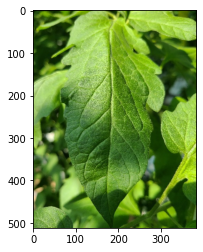

In [5]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)) # BGR is converted to RGB.
plt.show()

# https://note.nkmk.me/en/python-opencv-bgr-rgb-cvtcolor/

In [6]:
# json
sample_json

{'description': {'date': '20211014',
  'image': '10519.jpg',
  'task': 0,
  'width': 384,
  'time': '1105',
  'region': 0,
  'height': 512},
 'annotations': {'area': 3,
  'disease': '00',
  'grow': 13,
  'bbox': [{'x': 42.857142857142854,
    'h': 512.0,
    'y': 0.0,
    'w': 266.7261904761905}],
  'part': [],
  'risk': 0,
  'crop': 2}}

In [7]:
sample_json['annotations']['bbox'][0]

{'x': 42.857142857142854, 'h': 512.0, 'y': 0.0, 'w': 266.7261904761905}

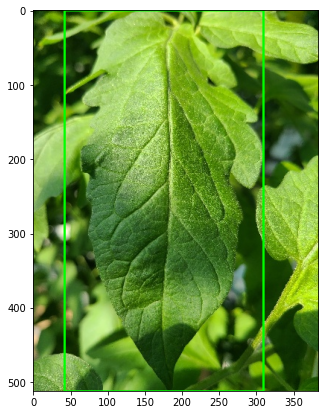

In [8]:
# visualize bbox (bounding box)
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0] # 주목 객체 바운딩 박스 (x, y, w, h 형태)
part_points = sample_json['annotations']['part'] # 병해 부위 바운딩 박스 (x, y, w, h 형태) 'part': [] - 위의 코드에서 sample_json - part는 값이 없다는 것을 알 수 있었음
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB) 

# cv2.rectangle(image, start_point, end_point, color, thickness)
cv2.rectangle( 
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0), # green color
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# https://copycoding.tistory.com/146

# 데이터 로드

## 환경 데이터 통계량 계산 for MinMax Scaling

- min-max scaling
- 최소값을 0, 최대값을 1로 하여 범위를 0~1로 변환하는 방법

In [9]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('data/train/*/*.csv')) # 환경 데이터 - 촬영 전 48 시간의 "측정 시각", "내부 온도", "내부 습도", "내부 이슬점", "내부 CO2", "외부 풍속", "외부 누적일사" 등의 환경 정보

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]): # tqdm 진행바(process bar) https://crazyj.tistory.com/167 
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|█████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:47<00:00, 121.56it/s]


{'내부 온도 1 평균': [3.4, 47.3],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 이슬점 평균': [0.1, 34.5],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4]}

## CustomDataset 제작

In [10]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [11]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:20]

# https://www.geeksforgeeks.org/python-dictionary-items-method/
# https://www.programiz.com/python-programming/methods/built-in/enumerate

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기'),
 ('1_b6_1', '딸기_다량원소결핍 (N)_초기'),
 ('1_b6_2', '딸기_다량원소결핍 (N)_중기'),
 ('1_b6_3', '딸기_다량원소결핍 (N)_말기'),
 ('1_b7_1', '딸기_다량원소결핍 (P)_초기'),
 ('1_b7_2', '딸기_다량원소결핍 (P)_중기'),
 ('1_b7_3', '딸기_다량원소결핍 (P)_말기'),
 ('1_b8_1', '딸기_다량원소결핍 (K)_초기'),
 ('1_b8_2', '딸기_다량원소결핍 (K)_중기'),
 ('1_b8_3', '딸기_다량원소결핍 (K)_말기'),
 ('2_00_0', '토마토_정상')]

In [12]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

# https://www.daleseo.com/python-enumerate/

In [13]:
label_encoder

{'1_00_0': 0,
 '1_a1_1': 1,
 '1_a1_2': 2,
 '1_a1_3': 3,
 '1_a2_1': 4,
 '1_a2_2': 5,
 '1_a2_3': 6,
 '1_b1_1': 7,
 '1_b1_2': 8,
 '1_b1_3': 9,
 '1_b6_1': 10,
 '1_b6_2': 11,
 '1_b6_3': 12,
 '1_b7_1': 13,
 '1_b7_2': 14,
 '1_b7_3': 15,
 '1_b8_1': 16,
 '1_b8_2': 17,
 '1_b8_3': 18,
 '2_00_0': 19,
 '2_a5_1': 20,
 '2_a5_2': 21,
 '2_a5_3': 22,
 '2_a6_1': 23,
 '2_a6_2': 24,
 '2_a6_3': 25,
 '2_b2_1': 26,
 '2_b2_2': 27,
 '2_b2_3': 28,
 '2_b3_1': 29,
 '2_b3_2': 30,
 '2_b3_3': 31,
 '2_b6_1': 32,
 '2_b6_2': 33,
 '2_b6_3': 34,
 '2_b7_1': 35,
 '2_b7_2': 36,
 '2_b7_3': 37,
 '2_b8_1': 38,
 '2_b8_2': 39,
 '2_b8_3': 40,
 '3_00_0': 41,
 '3_a9_1': 42,
 '3_a9_2': 43,
 '3_a9_3': 44,
 '3_a10_1': 45,
 '3_a10_2': 46,
 '3_a10_3': 47,
 '3_b3_1': 48,
 '3_b3_2': 49,
 '3_b3_3': 50,
 '3_b6_1': 51,
 '3_b6_2': 52,
 '3_b6_3': 53,
 '3_b7_1': 54,
 '3_b7_2': 55,
 '3_b7_3': 56,
 '3_b8_1': 57,
 '3_b8_2': 58,
 '3_b8_3': 59,
 '4_00_0': 60,
 '4_a3_1': 61,
 '4_a3_2': 62,
 '4_a3_3': 63,
 '4_a4_1': 64,
 '4_a4_2': 65,
 '4_a4_3': 66,
 '

In [14]:
label_decoder

{0: '1_00_0',
 1: '1_a1_1',
 2: '1_a1_2',
 3: '1_a1_3',
 4: '1_a2_1',
 5: '1_a2_2',
 6: '1_a2_3',
 7: '1_b1_1',
 8: '1_b1_2',
 9: '1_b1_3',
 10: '1_b6_1',
 11: '1_b6_2',
 12: '1_b6_3',
 13: '1_b7_1',
 14: '1_b7_2',
 15: '1_b7_3',
 16: '1_b8_1',
 17: '1_b8_2',
 18: '1_b8_3',
 19: '2_00_0',
 20: '2_a5_1',
 21: '2_a5_2',
 22: '2_a5_3',
 23: '2_a6_1',
 24: '2_a6_2',
 25: '2_a6_3',
 26: '2_b2_1',
 27: '2_b2_2',
 28: '2_b2_3',
 29: '2_b3_1',
 30: '2_b3_2',
 31: '2_b3_3',
 32: '2_b6_1',
 33: '2_b6_2',
 34: '2_b6_3',
 35: '2_b7_1',
 36: '2_b7_2',
 37: '2_b7_3',
 38: '2_b8_1',
 39: '2_b8_2',
 40: '2_b8_3',
 41: '3_00_0',
 42: '3_a9_1',
 43: '3_a9_2',
 44: '3_a9_3',
 45: '3_a10_1',
 46: '3_a10_2',
 47: '3_a10_3',
 48: '3_b3_1',
 49: '3_b3_2',
 50: '3_b3_3',
 51: '3_b6_1',
 52: '3_b6_2',
 53: '3_b6_3',
 54: '3_b7_1',
 55: '3_b7_2',
 56: '3_b7_3',
 57: '3_b8_1',
 58: '3_b8_2',
 59: '3_b8_3',
 60: '4_00_0',
 61: '4_a3_1',
 62: '4_a3_2',
 63: '4_a3_3',
 64: '4_a4_1',
 65: '4_a4_2',
 66: '4_a4_3',
 6

In [15]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# 하이퍼파라미터 및 변수

In [16]:
device = torch.device("cuda:0")
#batch_size = 256
batch_size = 128
class_n = len(label_encoder)
learning_rate = 1e-4
#embedding_dim = 512
embedding_dim = 256
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
#epochs = 10
epochs = 5
vision_pretrain = True
save_path = 'best_model.pt'

# 데이터셋 구성

In [17]:
train = sorted(glob('data/train/*'))
test = sorted(glob('data/test/*'))

labelsss = pd.read_csv('data/train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [18]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=16, shuffle=False)

C:\Users\MOK\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:474: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<span style="color:green"><b>16-22+ResNet 모델 설명 : 주영</b></span>

# 모델

## 이미지 분류 모델 : Resnet50

- Residual Network
- 50 layers deep
- p.220

**문제**
- back propagation으로 weight를 갱신할 때, 앞쪽 layer로 갈수록 weight가 작아지는 것을 볼 수 있음
- network (layer)가 깊어지게 되면 미분을 계속 하기에 weight가 계속 작아져 마지막에는 0으로 변해서 학습이 안되는 현상이 발생함 -> gradient vanishing
- layer를 계속 쌓기 어려웠음


**해결**
- ResNet에서는 앞 layer를 skip connection(스킵 연결)으로 다음 layer에 연결하게 되고, ReLU와 같은 활성함수를 같이 적용하면 gradient vanishing가 발생하지 않게 됨
- (layer 사이에 skip connection으로 연결해서 great gradient highway가 됨)

In [1]:
from IPython.display import Image

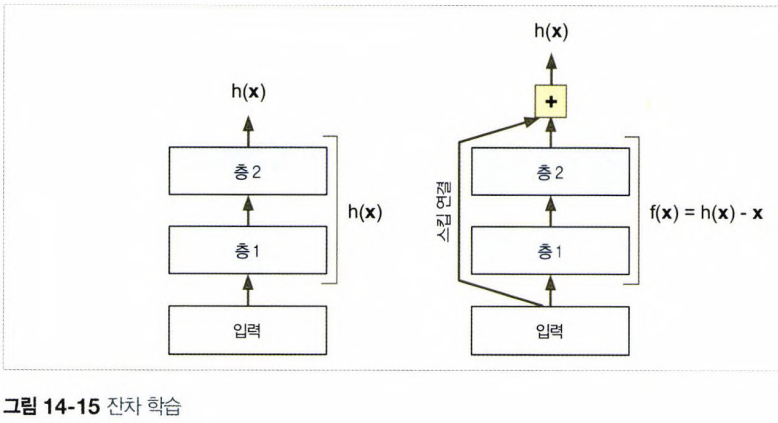

In [3]:
Image("residual.png")

**목적 함수의 변화**
- 왼쪽 기존 CNN 구조
    - 이전의 것이 다음으로 전달되는 과정에서 feature이 크게크게 변함
- 오른쪽 Residual 구조- 입력을 출력과 더해주는 형태 (입력을 출력에 그대로 더함 -> identity) -> feature를 추출하기 전 후
- 초기에는 identity function을 모델링함
    - 이전에서 얼만큼 변하는지(잔차)만 계산하는 문제가 되어 연산이 간단해지기 때문에 빠르게 학습이 가능해짐

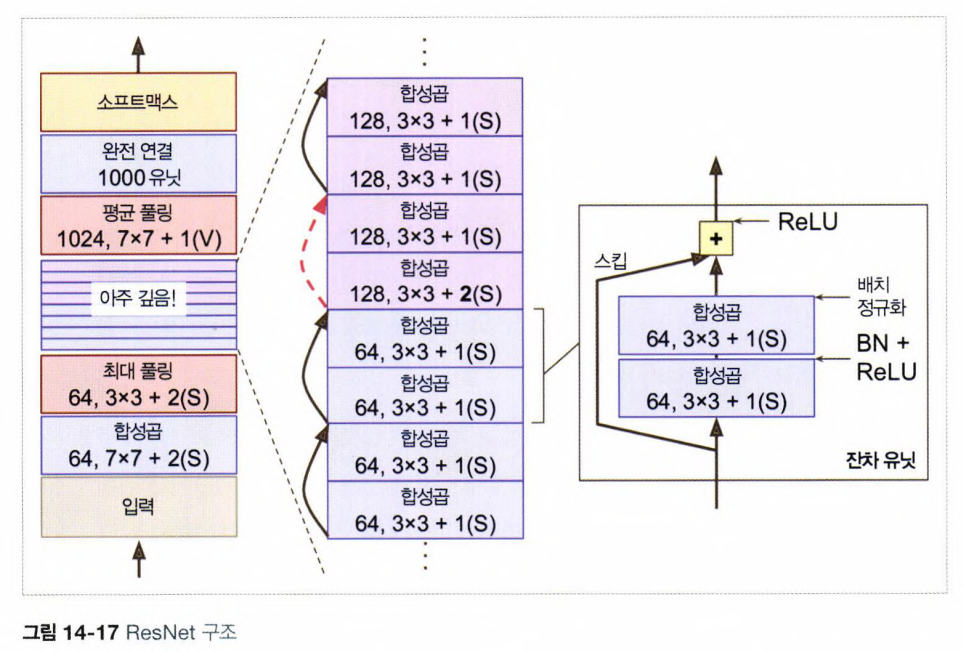

In [2]:
Image("resnet50.png")

In [22]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

- 장단기 메모리 Long short-term memory

- p.271

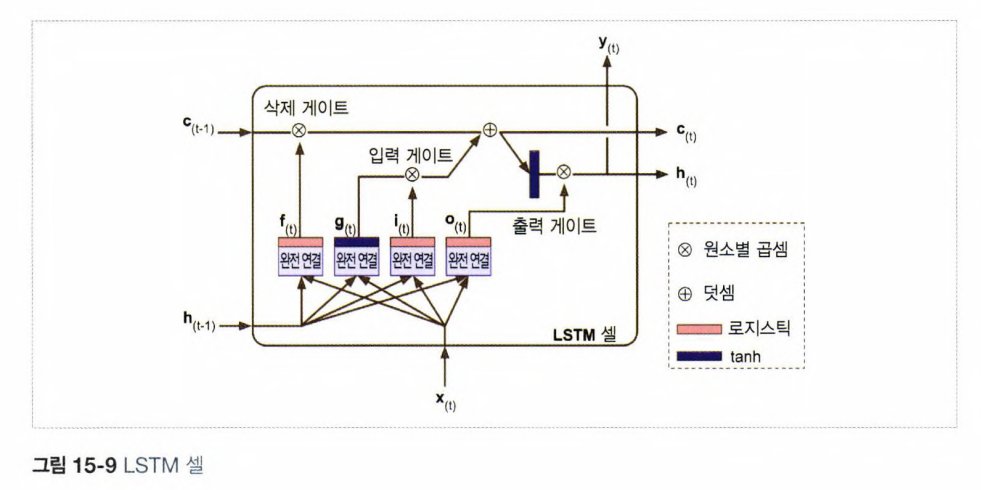

In [23]:
Image("lstm.png")

In [24]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

## 앙상블

In [25]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [26]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

# 학습

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

**엔트로피**

확률변수 x의 불확실성을 나타냄
(uncertainty)

In [28]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [ ]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), save_path)

<span style="color:green"><b>16-22+ResNet 모델 설명 : 주영</b></span>

# 학습 결과

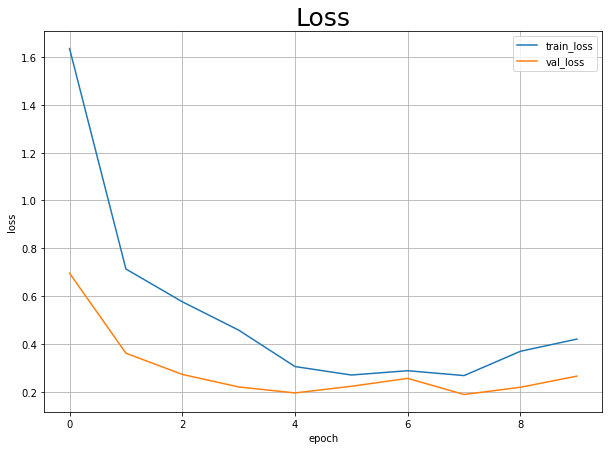

In [23]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

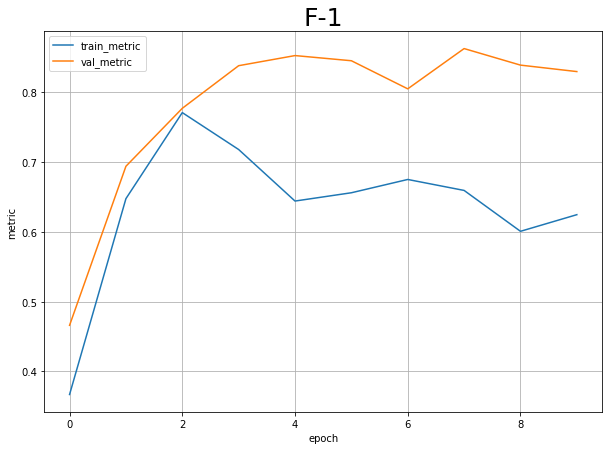

In [24]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

# 추론

In [25]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(test_dataloader)

0it [00:00, ?it/s]/tmp/ipykernel_23553/2570787494.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
203it [01:03,  3.18it/s]


In [26]:
preds = np.array([label_decoder[int(val)] for val in preds])

# 제출 파일 생성

In [27]:
submission = pd.read_csv('data/sample_submission.csv')
submission['label'] = preds
submission

,image,label
0,10000,6_00_0
1,10001,5_b6_1
2,10002,4_00_0
3,10003,3_00_0
4,10004,3_b8_1
...,...,...
51901,67673,4_00_0
51902,67674,3_b7_1
51903,67675,6_00_0
51904,67676,6_00_0


In [28]:
submission.to_csv('baseline_submission.csv', index=False)